In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("annnnguyen/metr-la-dataset")

print("Path to dataset files:", path)

Top-level keys in HDF5 file:
['df']
                        773869     767541     767542     717447     717446  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                        717445  773062  767620     737529     717816  ...  \
2012-03-01 00:00:00  68.750000  65.125  67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111  65.000  65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000  64.500  64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000   0.000   0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000   0.000   0.000   0.000000   0.000000  ...   

                        772167  

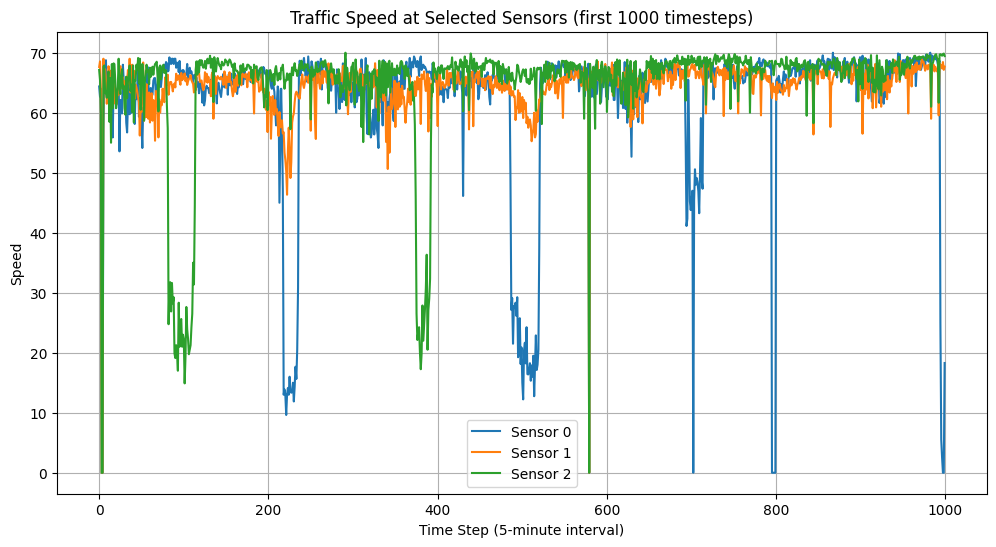

In [5]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd

# Load METR-LA data
h5path = 'metr-la.h5'

with h5py.File(h5path, 'r') as hf:
    print("Top-level keys in HDF5 file:")
    print(list(hf.keys()))
    
df = pd.read_hdf(h5path, key='df')
print(df.head())
print(df.shape)
    
data = df.to_numpy().astype(np.float32)

print("Loaded METR‑LA:", data.shape)

# Prepare sequences (past 12 → next 3, 5‑min intervals)
seq_len, pred_len = 12, 3
X, Y = [], []
for t in range(data.shape[0] - seq_len - pred_len + 1):
    X.append(data[t:t+seq_len])
    Y.append(data[t+seq_len:t+seq_len+pred_len])
X = np.stack(X)  # (S, 12, N)
Y = np.stack(Y)  # (S, 3, N)

# Dataset and DataLoader
class MetrDataset(Dataset):
    def __init__(self, X, Y):
        self.X, self.Y = X, Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return (torch.tensor(self.X[idx], dtype=torch.float32),
                torch.tensor(self.Y[idx], dtype=torch.float32))

ds = MetrDataset(X, Y)
dl = DataLoader(ds, batch_size=32, shuffle=True)

import matplotlib.pyplot as plt
import numpy as np

# Select a few sensors to visualize (e.g., sensors 0, 1, 2)
sensor_ids = [0, 1, 2]
num_points = 1000  # Number of time points to visualize

plt.figure(figsize=(12, 6))
for i, sid in enumerate(sensor_ids):
    plt.plot(data[:num_points, sid], label=f"Sensor {sid}")
plt.xlabel("Time Step (5-minute interval)")
plt.ylabel("Speed")
plt.title("Traffic Speed at Selected Sensors (first 1000 timesteps)")
plt.legend()
plt.grid(True)
plt.show()


### Historical Average

In [6]:
def historical_average(data, seq_len=12, pred_len=3):
    """
    data: (T, N) array of traffic speeds
    Returns: predictions using historical average for each time of day
    """
    T, N = data.shape
    X, Y_pred = [], []
    for t in range(seq_len, T - pred_len):
        past = data[t - seq_len:t]
        target_time_idx = t % 288  # 288 points/day for 5-min intervals
        # Mean of the same time point on previous days
        past_same_times = data[target_time_idx::288][:t//288]
        if len(past_same_times) < 1:
            continue
        avg = np.mean(past_same_times, axis=0)
        X.append(data[t - seq_len:t])
        Y_pred.append(np.tile(avg, (pred_len, 1)))
    return np.stack(X), np.stack(Y_pred)

# calculate the MSE of the historical average
X_avg, Y_avg = historical_average(data, seq_len=seq_len, pred_len=pred_len)
mse_avg = np.mean((Y_avg - Y[:Y_avg.shape[0]]) ** 2)
print("Historical average MSE:", mse_avg)

Historical average MSE: 349.6424


### Simple MLP

In [36]:
class TrafficMLP(nn.Module):
    def __init__(self, seq_len, num_sensors, pred_len, hidden_dim=128):
        super().__init__()
        self.input_dim = seq_len * num_sensors
        self.output_dim = pred_len * num_sensors
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )
        self.seq_len = seq_len
        self.num_sensors = num_sensors
        self.pred_len = pred_len

    def forward(self, x):
        B = x.size(0)
        x = x.view(B, -1)  # flatten to (B, seq_len * num_sensors)
        out = self.net(x)  # (B, pred_len * num_sensors)
        return out.view(B, self.pred_len, self.num_sensors)

### Traffic Transformer

In [157]:
class TrafficTransformer(nn.Module):
    def __init__(self, num_sensors, seq_len, model_dim=128, nhead=8, num_layers=4, pred_len=3):
        super().__init__()
        self.num_sensors = num_sensors
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.model_dim = model_dim

        self.embed = nn.Linear(num_sensors, model_dim)
        self.pos_emb = nn.Parameter(torch.randn(seq_len, model_dim))  # (T, D)
        self.sensor_emb = nn.Parameter(torch.randn(num_sensors, model_dim))  # (N, D)

        self.dropout = nn.Dropout(0.1)
        self.norm = nn.LayerNorm(model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=nhead, dropout=0.1)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.decoder = nn.Linear(model_dim, num_sensors * pred_len)

    def forward(self, x):
        # x shape: (B, T, N)
        x = self.embed(x)  # (B, T, D)
        B, T, D = x.shape

        # Add temporal positional encoding
        pos = self.pos_emb[:T].unsqueeze(0)  # (1, T, D)
        x = x + pos

        # Add sensor embeddings
        sensor_embed = self.sensor_emb.unsqueeze(0).unsqueeze(1)  # (1, 1, N, D)
        sensor_embed = sensor_embed.expand(B, T, -1, -1)  # (B, T, N, D)
        sensor_embed = sensor_embed.mean(dim=2)  # (B, T, D) – averaged across sensors
        x = x + sensor_embed

        x = self.dropout(self.norm(x))
        x = x.permute(1, 0, 2)  # (T, B, D)

        x = self.encoder(x)
        out = x[-1]  # (B, D)

        pred = self.decoder(out)  # (B, N * pred_len)
        return pred.view(-1, self.pred_len, self.num_sensors)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Data and Training Logic

In [158]:
# Normalize data (min-max per sensor)
min_val = data.min(axis=0, keepdims=True)
max_val = data.max(axis=0, keepdims=True)
data = (data - min_val) / (max_val - min_val + 1e-5)

# Sequence lengths
seq_len, pred_len = 12, 3
X, Y = [], []
for t in range(data.shape[0] - seq_len - pred_len + 1):
    X.append(data[t:t+seq_len])
    Y.append(data[t+seq_len:t+seq_len+pred_len])
X = np.stack(X)
Y = np.stack(Y)

# Split: 60% train, 20% val, 20% test
n = len(X)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Create DataLoaders
train_dl = DataLoader(MetrDataset(X_train, Y_train), batch_size=32, shuffle=True)
val_dl = DataLoader(MetrDataset(X_val, Y_val), batch_size=32, shuffle=False)
test_dl = DataLoader(MetrDataset(X_test, Y_test), batch_size=32, shuffle=False)

def train_model(model, train_dl, val_dl, loss_fn, opt, device, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        # Train
        model.train()
        total_loss = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        mse_horizon_sum = torch.zeros(yb.shape[1], device=device)  # pred_len
        count = 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
                mse_horizon_sum += ((pred - yb) ** 2).mean(dim=(0, 2))  # (pred_len,)
                count += 1
                
        scheduler.step()

        mse_per_horizon = (mse_horizon_sum / count).cpu().numpy()
        print(f"Epoch {epoch+1} | Train MSE = {total_loss/len(train_dl):.4f} | Val MSE = {val_loss/len(val_dl):.4f}")
        print(f"  Horizon MSEs: {mse_per_horizon}")
        
def test_model(model, test_dl, loss_fn, device):
    model.eval()
    total_loss = 0
    mse_horizon_sum = None
    count = 0

    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += loss_fn(pred, yb).item()
            if mse_horizon_sum is None:
                mse_horizon_sum = torch.zeros(yb.shape[1], device=device)
            mse_horizon_sum += ((pred - yb) ** 2).mean(dim=(0, 2))
            count += 1

    mse_avg = total_loss / len(test_dl)
    mse_per_horizon = (mse_horizon_sum / count).cpu().numpy()
    print(f"Test MSE = {mse_avg:.4f}")
    print(f"Test MSE per horizon: {mse_per_horizon}")
    return mse_avg, mse_per_horizon


Train: (20554, 12, 207), Val: (6852, 12, 207), Test: (6852, 12, 207)


### Some results

In [122]:
X_avg, Y_avg = historical_average(data, seq_len=seq_len, pred_len=pred_len)
mse_avg = np.mean((Y_avg - Y[:Y_avg.shape[0]]) ** 2)
print("Historical average MSE:", mse_avg)

Historical average MSE: 0.071489446


In [123]:
model = TrafficMLP(seq_len, data.shape[1], pred_len)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

train_model(model, train_dl, val_dl, loss_fn, opt, device, num_epochs=20)
test_model(model, test_dl, loss_fn, device)

Epoch 1 | Train MSE = 0.0372 | Val MSE = 0.0306
  Horizon MSEs: [0.0289121  0.03084496 0.03210517]
Epoch 2 | Train MSE = 0.0223 | Val MSE = 0.0283
  Horizon MSEs: [0.02638692 0.02831252 0.03024292]
Epoch 3 | Train MSE = 0.0201 | Val MSE = 0.0277
  Horizon MSEs: [0.02615305 0.02776375 0.0293321 ]
Epoch 4 | Train MSE = 0.0183 | Val MSE = 0.0244
  Horizon MSEs: [0.02241318 0.02457888 0.02632314]
Epoch 5 | Train MSE = 0.0178 | Val MSE = 0.0240
  Horizon MSEs: [0.02218389 0.02402006 0.02579203]
Epoch 6 | Train MSE = 0.0174 | Val MSE = 0.0236
  Horizon MSEs: [0.02136722 0.02367025 0.02563156]
Epoch 7 | Train MSE = 0.0167 | Val MSE = 0.0229
  Horizon MSEs: [0.02088088 0.02301428 0.02484857]
Epoch 8 | Train MSE = 0.0166 | Val MSE = 0.0228
  Horizon MSEs: [0.02075615 0.02296932 0.02481093]
Epoch 9 | Train MSE = 0.0165 | Val MSE = 0.0227
  Horizon MSEs: [0.0206234  0.02283416 0.0246274 ]
Epoch 10 | Train MSE = 0.0161 | Val MSE = 0.0225
  Horizon MSEs: [0.02042672 0.02262402 0.02442122]
Epoch 11 

(0.025578291562580784,
 array([0.02218696, 0.02583853, 0.02870939], dtype=float32))

In [159]:
model = TrafficTransformer(num_sensors=data.shape[1], seq_len=seq_len, pred_len=pred_len)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.9)

train_model(model, train_dl, val_dl, loss_fn, opt, device, num_epochs=10)
test_model(model, test_dl, loss_fn, device)

c:\Users\GAUSS\anaconda3\envs\torch310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 | Train MSE = 0.0469 | Val MSE = 0.0350
  Horizon MSEs: [0.03295507 0.035396   0.03657723]
Epoch 2 | Train MSE = 0.0255 | Val MSE = 0.0286
  Horizon MSEs: [0.02645942 0.028798   0.03047414]
Epoch 3 | Train MSE = 0.0214 | Val MSE = 0.0267
  Horizon MSEs: [0.02522741 0.02659617 0.02838135]
Epoch 4 | Train MSE = 0.0189 | Val MSE = 0.0239
  Horizon MSEs: [0.02190734 0.02390425 0.0259168 ]
Epoch 5 | Train MSE = 0.0181 | Val MSE = 0.0233
  Horizon MSEs: [0.02112    0.02338694 0.02530919]
Epoch 6 | Train MSE = 0.0167 | Val MSE = 0.0214
  Horizon MSEs: [0.0191377  0.02146724 0.02344572]
Epoch 7 | Train MSE = 0.0161 | Val MSE = 0.0220
  Horizon MSEs: [0.01993165 0.02203247 0.02401127]
Epoch 8 | Train MSE = 0.0181 | Val MSE = 0.0229
  Horizon MSEs: [0.02053756 0.02353259 0.02451254]
Epoch 9 | Train MSE = 0.0162 | Val MSE = 0.0218
  Horizon MSEs: [0.01967409 0.02195348 0.02391406]
Epoch 10 | Train MSE = 0.0155 | Val MSE = 0.0228
  Horizon MSEs: [0.02052395 0.02288658 0.02490848]
Test MSE 

(0.024932979400334662,
 array([0.021592  , 0.02515526, 0.02805167], dtype=float32))

### Visualization

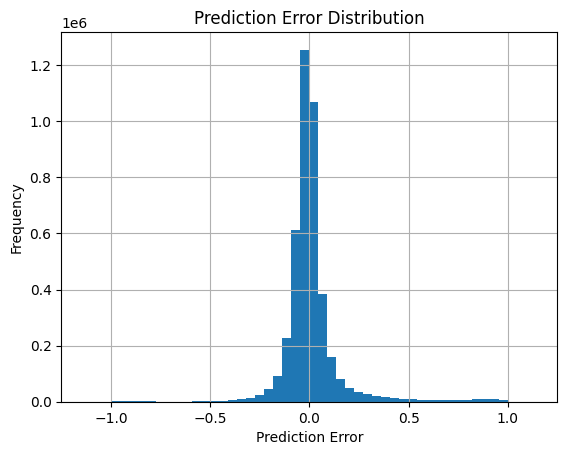

In [161]:
errors = []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        errors.extend((pred - yb).cpu().numpy().flatten())

plt.hist(errors, bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


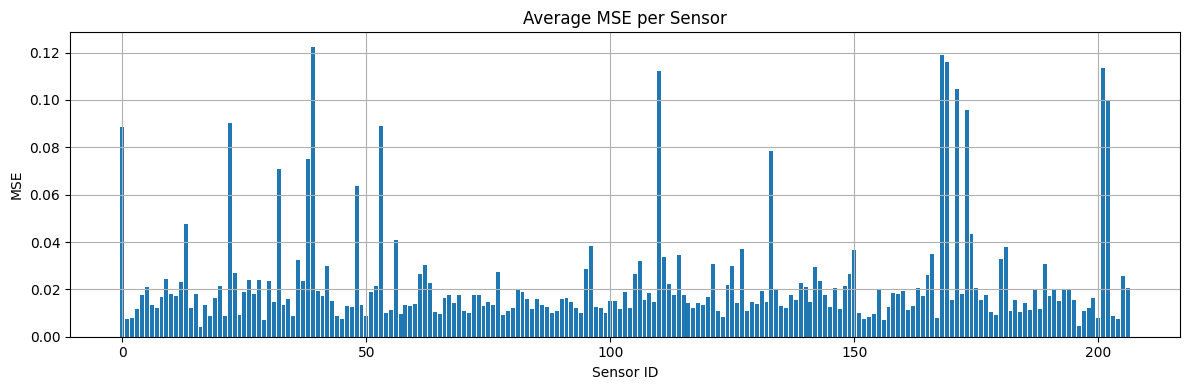

In [162]:
sensor_mse = np.zeros(X.shape[2])
counts = np.zeros(X.shape[2])

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).cpu().numpy()
        yb = yb.cpu().numpy()
        err = (pred - yb) ** 2
        sensor_mse += err.sum(axis=(0, 1))  # sum over batch and time
        counts += err.shape[0] * err.shape[1]  # batch * time steps

avg_sensor_mse = sensor_mse / counts

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(avg_sensor_mse)), avg_sensor_mse)
plt.title("Average MSE per Sensor")
plt.xlabel("Sensor ID")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()


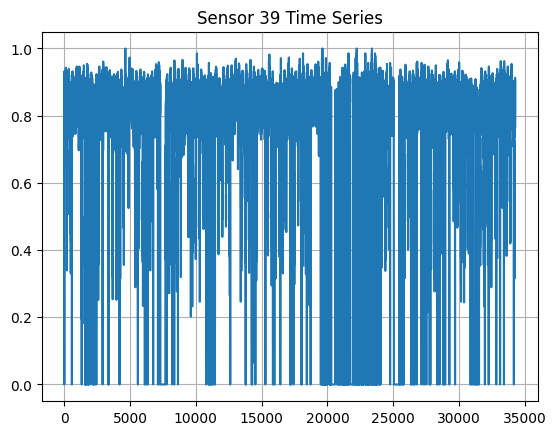

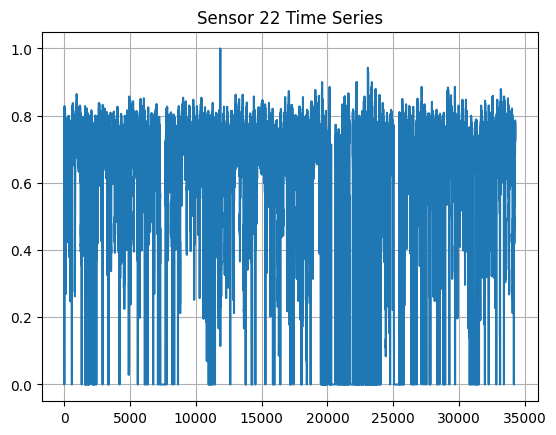

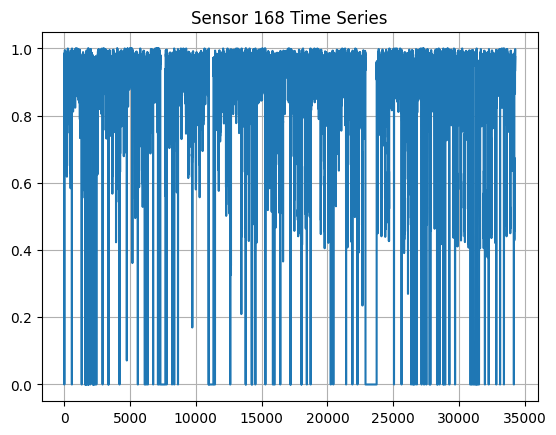

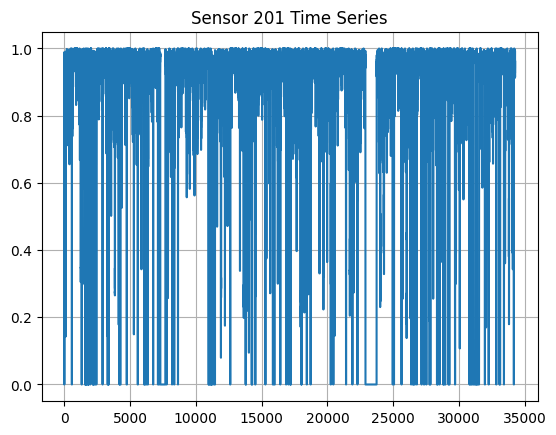

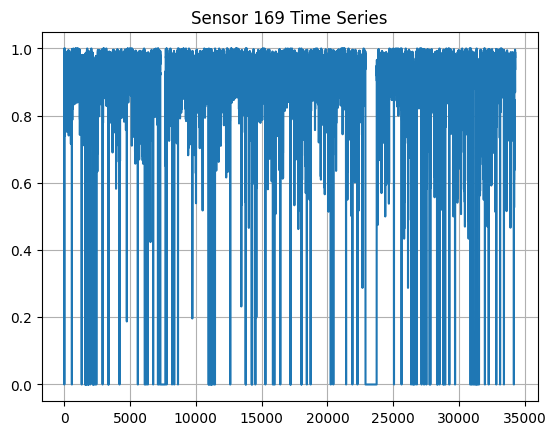

In [49]:
# Get top-k worst sensors
worst = avg_sensor_mse.argsort()[-5:][::-1]
for sid in worst:
    plt.figure()
    plt.plot(data[:, sid])
    plt.title(f"Sensor {sid} Time Series")
    plt.grid(True)
    plt.show()


### Graphical Attention Model

C:\Users\GAUSS\AppData\Local\Temp\ipykernel_4796\1228050777.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


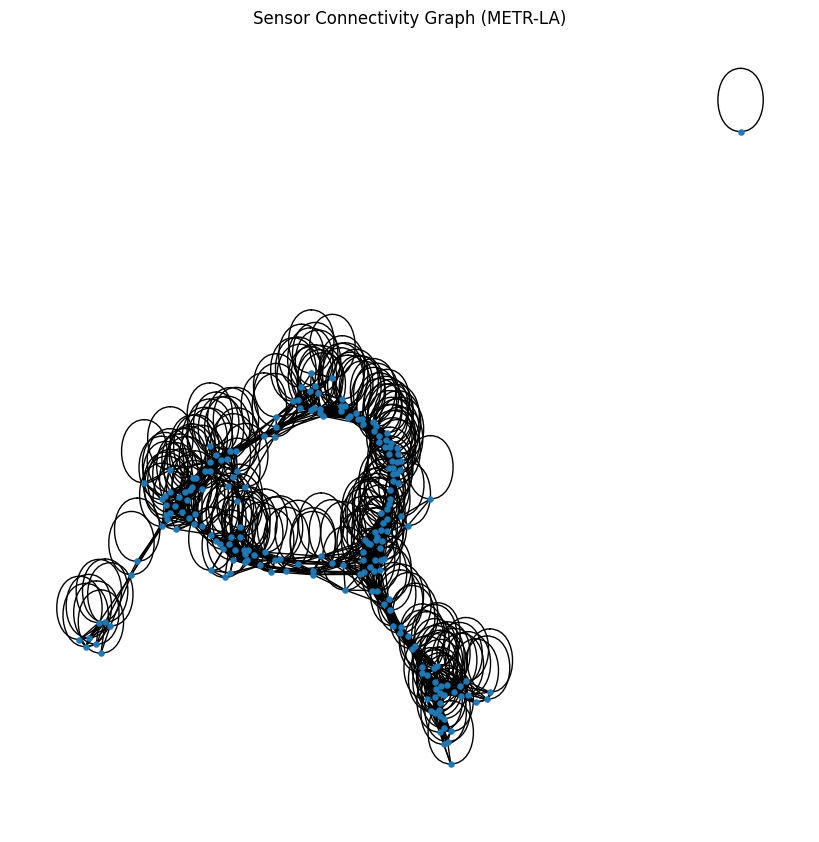

Adjacency matrix shape: torch.Size([207, 207])
edge_index shape: torch.Size([2, 1722])


In [164]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
import networkx as nx

# === Load and process adjacency matrix ===
with open("adj_METR-LA.pkl", "rb") as f:
    sensor_ids, sensor_id_to_ind, adj_mx = pickle.load(f, encoding="latin1")

G = nx.Graph()
N = len(adj_mx)
G.add_nodes_from(range(N))
for i in range(N):
    for j in range(N):
        if adj_mx[i][j] > 0:
            G.add_edge(i, j)

# 3) Layout & plot
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, seed=42)      # force‐directed layout
nx.draw(G, pos,
        with_labels=False,
        node_size=20,
        linewidths=0.2)
plt.title("Sensor Connectivity Graph (METR-LA)")
plt.tight_layout()
plt.show()

adj_tensor = torch.tensor(adj_mx, dtype=torch.float32)
edge_index = (adj_tensor > 0).nonzero(as_tuple=False).T  # [2, num_edges]
edge_index = edge_index.to(device)

print(f"Adjacency matrix shape: {adj_tensor.shape}")
print(f"edge_index shape: {edge_index.shape}")

num_nodes = adj_tensor.shape[0]

# Convert each (i, j) pair to a unique ID using: edge_id = i * N + j
edge_ids = edge_index[0] * num_nodes + edge_index[1]  # shape [E]
edge_ids = edge_ids.to(device)

# === Define GAT + GRU model ===
class GATBlock(nn.Module):
    def __init__(self, in_channels, out_channels, heads=1):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=True)

    def forward(self, x, edge_index):
        return F.elu(self.gat(x, edge_index))

class GATTransformer(nn.Module):
    def __init__(self, num_nodes, input_len, pred_len, edge_index, gat_in=1, gat_hidden=12, num_heads=4):
        super().__init__()
        self.edge_index = edge_index
        self.num_nodes = num_nodes
        self.input_len = input_len
        self.gat_in = gat_in
        self.gat_hidden = gat_hidden
        self.num_heads = num_heads

        self.input_proj = nn.Linear(1, gat_in)  # [B*N, 1] -> [B*N, in]
        self.gat1 = GATBlock(gat_in, gat_hidden, heads=num_heads)
        self.gat2 = GATBlock(gat_hidden * num_heads, gat_hidden, heads=1)
        self.gru = nn.GRU(gat_hidden, gat_hidden, batch_first=True)
        self.out_proj = nn.Linear(gat_hidden, pred_len)

    def forward(self, x):
        # x: [B, T, N]
        B, T, N = x.shape
        x = x.permute(0, 2, 1).reshape(B * N, T, 1)   # [B*N, T, 1]
        x = self.input_proj(x)  # [B*N, T, in]
        x = x.view(B, N, T, -1)  # [B, N, T, in]

        gat_out = []
        for t in range(T):
            x_t = x[:, :, t, :]  # [B, N, in]
            x_t = x_t.reshape(B * N, -1)  # flatten for GAT
            h1 = self.gat1(x_t, self.edge_index)  # [B*N, H*heads]
            h2 = self.gat2(h1, self.edge_index)   # [B*N, H]
            h2 = h2.view(B, N, -1)                # [B, N, H]
            gat_out.append(h2.unsqueeze(1))       # [B, 1, N, H]

        x_gat = torch.cat(gat_out, dim=1)  # [B, T, N, H]
        x_gat = x_gat.permute(0, 2, 1, 3).reshape(B * N, T, -1)  # [B*N, T, H]
        x_gat, _ = self.gru(x_gat)  # [B*N, T, H]
        out = self.out_proj(x_gat[:, -1])  # [B*N, pred_len]
        out = out.view(B, N, -1).permute(0, 2, 1)  # [B, pred_len, N]
        return out

def train_model(model, train_dl, val_dl, loss_fn, opt, device, edge_index, edge_weight=None, scheduler=None, num_epochs=5):
    model.to(device)
    edge_index = edge_index.to(device)
    if edge_weight is not None:
        edge_weight = edge_weight.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()

        model.eval()
        val_loss, mse_horizon_sum, count = 0, torch.zeros(yb.shape[1], device=device), 0

        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb)
                val_loss += loss_fn(pred, yb).item()
                mse_horizon_sum += ((pred - yb) ** 2).mean(dim=(0, 2))
                count += 1

        if scheduler: scheduler.step()
        mse_per_horizon = (mse_horizon_sum / count).cpu().numpy()

        print(f"Epoch {epoch+1} | Train MSE = {total_loss / len(train_dl):.4f} | Val MSE = {val_loss / len(val_dl):.4f}")
        print(f"  Horizon MSEs: {mse_per_horizon}")

def test_model(model, test_dl, loss_fn, device, edge_index, edge_weight=None):
    model.to(device)
    model.eval()
    edge_index = edge_index.to(device)
    if edge_weight is not None:
        edge_weight = edge_weight.to(device)

    total_loss, count = 0, 0
    mse_horizon_sum = None

    with torch.no_grad():
        for xb, yb in test_dl:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += loss_fn(pred, yb).item()

            if mse_horizon_sum is None:
                mse_horizon_sum = torch.zeros(yb.shape[1], device=device)

            mse_horizon_sum += ((pred - yb) ** 2).mean(dim=(0, 2))
            count += 1

    mse_avg = total_loss / len(test_dl)
    mse_per_horizon = (mse_horizon_sum / count).cpu().numpy()

    print(f"Test MSE = {mse_avg:.4f}")
    print(f"Test MSE per horizon: {mse_per_horizon}")
    return mse_avg, mse_per_horizon


In [135]:
model = GATTransformer(
    num_nodes=data.shape[1],      # N
    input_len=seq_len,            # T (input sequence length)
    pred_len=pred_len,            # future prediction steps
    edge_index=edge_index,        # from adjacency matrix
    gat_in=1,                     # since input feature per time step is scalar
    gat_hidden=12,                # hidden dim per GAT layer
    num_heads=4                   # number of attention heads
)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

# Train and evaluate
train_model(model, train_dl, val_dl, loss_fn, opt, device, edge_index, scheduler=scheduler, num_epochs=20)
test_model(model, test_dl, loss_fn, device, edge_index)


Epoch 1 | Train MSE = 0.0605 | Val MSE = 0.0135
  Horizon MSEs: [0.00924787 0.01294318 0.018212  ]
Epoch 2 | Train MSE = 0.0138 | Val MSE = 0.0122
  Horizon MSEs: [0.00824809 0.01232029 0.01595913]
Epoch 3 | Train MSE = 0.0135 | Val MSE = 0.0118
  Horizon MSEs: [0.00807918 0.01187558 0.01545395]
Epoch 4 | Train MSE = 0.0132 | Val MSE = 0.0117
  Horizon MSEs: [0.00798981 0.01187096 0.01538788]
Epoch 5 | Train MSE = 0.0133 | Val MSE = 0.0117
  Horizon MSEs: [0.0079954  0.01183116 0.01521074]
Epoch 6 | Train MSE = 0.0132 | Val MSE = 0.0117
  Horizon MSEs: [0.00795796 0.01183725 0.01518694]
Epoch 7 | Train MSE = 0.0131 | Val MSE = 0.0117
  Horizon MSEs: [0.00798997 0.01194788 0.01518395]
Epoch 8 | Train MSE = 0.0131 | Val MSE = 0.0117
  Horizon MSEs: [0.0079651  0.0118316  0.01515843]
Epoch 9 | Train MSE = 0.0131 | Val MSE = 0.0117
  Horizon MSEs: [0.00796252 0.01182546 0.01518249]
Epoch 10 | Train MSE = 0.0130 | Val MSE = 0.0116
  Horizon MSEs: [0.00796022 0.0118187  0.01512135]
Epoch 11 

(0.01470935975233916,
 array([0.00981626, 0.01495483, 0.01935699], dtype=float32))

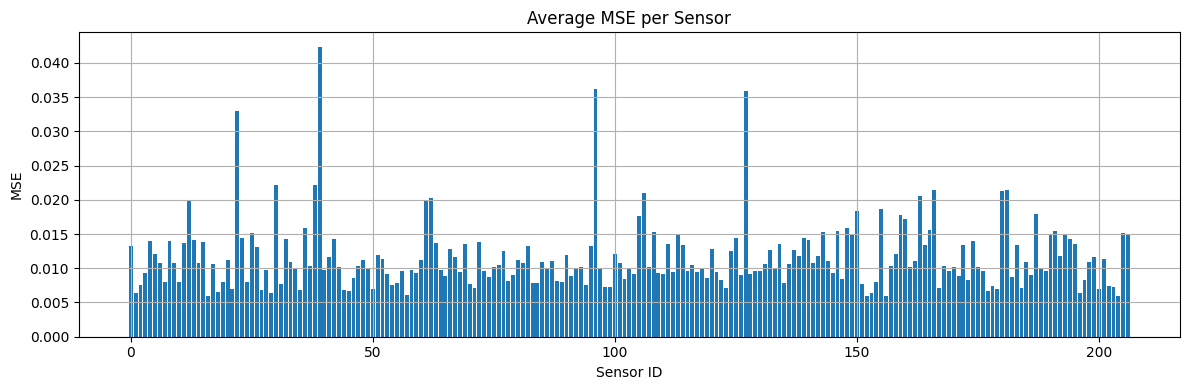

In [136]:
sensor_mse = np.zeros(X.shape[2])
counts = np.zeros(X.shape[2])

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).cpu().numpy()
        yb = yb.cpu().numpy()
        err = (pred - yb) ** 2
        sensor_mse += err.sum(axis=(0, 1))  # sum over batch and time
        counts += err.shape[0] * err.shape[1]  # batch * time steps

avg_sensor_mse = sensor_mse / counts

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(avg_sensor_mse)), avg_sensor_mse)
plt.title("Average MSE per Sensor")
plt.xlabel("Sensor ID")
plt.ylabel("MSE")
plt.grid(True)
plt.tight_layout()
plt.show()
